# Model Error Analysis - Tutorial

Install the [Model Error Analysis plugin](http://urllink to the documentation) and import the required libraries.

In [22]:
import dataiku

In [23]:
dataiku.use_plugin_libs('model-error-analysis')
from dku_error_analysis_mpp.error_analyzer import ErrorAnalyzer
from dku_error_analysis_mpp.error_visualizer import ErrorVisualizer, DkuErrorVisualizer
from dku_error_analysis_mpp.dku_error_analyzer import DkuErrorAnalyzer
from dku_error_analysis_model_parser.model_accessor import ModelAccessor
from dku_error_analysis_model_parser.model_metadata import *

In [24]:
%matplotlib inline

## Load a trained primary model

Load any trained DSS classification or regression model. This is your _Primary Model_.

Replace the `lookup` and `version_id` placeholders with your own model identifiers.

In [25]:
lookup='kc_house model'
version_id='initial'

Build an accessor to your model through `get_model_handler` and `ModelAccessor`.

In [26]:
m = dataiku.Model(lookup)
model_handler = get_model_handler(m, version_id)
model_accessor = ModelAccessor(model_handler)

Error Analysis Plugin | INFO - Post-processing model
Error Analysis Plugin | INFO - generating interactions
Error Analysis Plugin | INFO - {u'preprocessingFitSampleSeed': 1337, u'feature_selection_params': {u'custom_params': {u'code': u'# type your code here'}, u'pca_params': {u'variance_proportion': 0.9, u'n_features': 25}, u'random_forest_params': {u'depth': 10, u'n_features': 25, u'n_trees': 30}, u'lasso_params': {u'alpha': [0.01, 0.1, 1.0, 10.0, 100.0], u'cross_validate': True}, u'method': u'NONE', u'correlation_params': {u'max_abs_correlation': 1.0, u'n_features': 25, u'min_abs_correlation': 0.0}}, u'preprocessingFitSampleRatio': 1.0, u'reduce': {u'enabled': False, u'kept_variance': 0.0}, u'skipPreprocessing': False, u'target_remapping': [], u'per_feature': {u'bathrooms': {u'generate_derivative': False, u'sendToInput': u'main', u'rescaling': u'AVGSTD', u'role': u'INPUT', u'customHandlingCode': u'', u'customProcessorWantsMatrix': False, u'numerical_handling': u'REGULAR', u'binarize

Error Analysis Plugin | INFO - No feature selection to perform
Error Analysis Plugin | INFO - generating interactions
Error Analysis Plugin | INFO - {u'preprocessingFitSampleSeed': 1337, u'feature_selection_params': {u'custom_params': {u'code': u'# type your code here'}, u'pca_params': {u'variance_proportion': 0.9, u'n_features': 25}, u'random_forest_params': {u'depth': 10, u'n_features': 25, u'n_trees': 30}, u'lasso_params': {u'alpha': [0.01, 0.1, 1.0, 10.0, 100.0], u'cross_validate': True}, u'method': u'NONE', u'correlation_params': {u'max_abs_correlation': 1.0, u'n_features': 25, u'min_abs_correlation': 0.0}}, u'preprocessingFitSampleRatio': 1.0, u'reduce': {u'enabled': False, u'kept_variance': 0.0}, u'skipPreprocessing': False, u'target_remapping': [], u'per_feature': {u'bathrooms': {u'generate_derivative': False, u'sendToInput': u'main', u'rescaling': u'AVGSTD', u'role': u'INPUT', u'customHandlingCode': u'', u'customProcessorWantsMatrix': False, u'numerical_handling': u'REGULAR', 

Error Analysis Plugin | INFO - No feature selection to perform
Error Analysis Plugin | INFO - Set MF index len 1
Error Analysis Plugin | DEBUG - PROCESS WITH Step:MultipleImputeMissingFromInput
Error Analysis Plugin | DEBUG - MIMIFI: Imputing with map {u'sqft_basement': 292.1499220058929, u'bathrooms': 2.1116904500548848, u'sqft_above': 1787.3483736784333, u'sqft_lot15': 12799.77994107112, u'grade': 7.651568548154139, u'yr_renovated': 85.22496966895835, u'bedrooms': 3.370789762551274, u'zipcode': 98078.2656999249, u'long': -122.21427482812423, u'sqft_living': 2079.498295684326, u'floors': 1.4951470333352592, u'condition': 3.4050493962678376, u'view': 0.2379686868103299, u'lat': 47.56039116066808, u'waterfront': 0.00779941071119071, u'yr_built': 1970.9281298746316, u'sqft_lot': 15330.516667629558, u'sqft_living15': 1983.1994338205557}
Error Analysis Plugin | DEBUG - PROCESS WITH Step:RescalingProcessor2 (bathrooms)
Error Analysis Plugin | DEBUG -   Rescale bathrooms (avg=2.1116904500548

## Use a DkuErrorAnalyzer

Instantiate a `DkuErrorAnalyzer` object with your model accessor.

In [27]:
dku_error_analyzer = DkuErrorAnalyzer(model_accessor)

Fit the underlying <font color=red>_Model Performance Predictor_ (MPP)</font> to your DSS model performances on its test set.

In [28]:
dku_error_analyzer.fit()

Error Analysis Plugin | INFO - Reading with dtypes: None
Error Analysis Plugin | INFO - Computed dtype for id: None (schema_type=string feature_type=CATEGORY feature_role=REJECT)
Error Analysis Plugin | INFO - Computed dtype for date: str (schema_type=string feature_type=CATEGORY feature_role=INPUT)
Error Analysis Plugin | INFO - Computed dtype for price: <type 'numpy.float64'> (schema_type=double feature_type=NUMERIC feature_role=TARGET)
Error Analysis Plugin | INFO - Computed dtype for bedrooms: <type 'numpy.float64'> (schema_type=bigint feature_type=NUMERIC feature_role=INPUT)
Error Analysis Plugin | INFO - Computed dtype for bathrooms: <type 'numpy.float64'> (schema_type=double feature_type=NUMERIC feature_role=INPUT)
Error Analysis Plugin | INFO - Computed dtype for sqft_living: <type 'numpy.float64'> (schema_type=bigint feature_type=NUMERIC feature_role=INPUT)
Error Analysis Plugin | INFO - Computed dtype for sqft_lot: <type 'numpy.float64'> (schema_type=bigint feature_type=NUMER

Error Analysis Plugin | DEBUG -   Rescale floors (avg=1.490938661710037 std=0.5365226188355177 shift=1.49514703334 inv_scale=1.84890892457)
Error Analysis Plugin | DEBUG -   Rescaled floors (avg=-0.00778089585578228 std=0.9919814581989164) nulls=0
Error Analysis Plugin | DEBUG - PROCESS WITH Step:RescalingProcessor2 (sqft_lot)
Error Analysis Plugin | DEBUG -   Rescale sqft_lot (avg=14207.940752788105 std=34601.95474189959 shift=15330.5166676 inv_scale=2.32849287143e-05)
Error Analysis Plugin | DEBUG -   Rescaled sqft_lot (avg=-0.026139100153487173 std=0.8057040495409928) nulls=0
Error Analysis Plugin | DEBUG - PROCESS WITH Step:RescalingProcessor2 (lat)
Error Analysis Plugin | DEBUG -   Rescale lat (avg=47.5586906366171 std=0.13926283675920403 shift=47.5603911607 inv_scale=7.22588895309)
Error Analysis Plugin | DEBUG -   Rescaled lat (avg=-0.012287797954450461 std=1.0062977937138997) nulls=0
Error Analysis Plugin | DEBUG - PROCESS WITH Step:RescalingProcessor2 (waterfront)
Error Analys

### Model Performance Predictor

The underlying MPP can be retrieved by the attribute `model_performance_predictor`.

You can see that it consists in a `DecisionTree` from `sklearn` predicting _Correct_ or _Wrong Prediction_.

In [31]:
error_clf = dku_error_analyzer.model_performance_predictor
print(error_clf)
print(error_clf.classes_)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=65537, splitter='best')
['Correct prediction' 'Wrong prediction']


The features used in the MPP can be retrieved by the attribute `model_performance_predictor_features`. 

These features are the very same used by your primary model.

In [32]:
feature_names = dku_error_analyzer.model_performance_predictor_features
feature_names[:3]

[u'bathrooms', u'bedrooms', u'condition']

### Model Performance Predictor Metrics

You can have a report on the MPP thanks to the `mpp_summary` function as a text or formatted output. 

This will output some metrics computed on a part of the test set of your DSS model:
1. the MPP accuracy score
2. the estimated accuracy of your primary model according to the MPP
3. the true accuracy of your primary model
4. the _Fidelity_ of the MPP (absolute deviation of 2. and 3.)

Ideally the two values 2. and 3. above should be equal, thus their deviation (_Fidelity_) is computed as an indicator of how well the MPP represents your model performances.

The _Confidence Decision_ states whether you can trust the MPP as a representation of your model performances.

In [33]:
print(dku_error_analyzer.mpp_summary(output_dict=False))

The MPP was trained with accuracy 89.55%.
The Decision Tree estimated the primary models accuracy to 98.84%.
The true accuracy of the primary model is 89.55.%
The Fidelity of the MPP is 90.71%.
The MPP is considered representative of the primary model performances.



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [34]:
dku_error_analyzer.mpp_summary(output_dict=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


{'confidence_decision': True,
 'mpp_accuracy_score': 0.8954703832752613,
 'primary_model_predicted_accuracy': 0.9883855981416957,
 'primary_model_true_accuracy': 0.8954703832752613}

### Use the Model Performance Predictor on new data

You can also compute the metrics on a different dataset instead of your model test set.

Replace `extra_testset_name` with your extra dataset (same schema as you training and test set). 

In [35]:
extra_testset_name = 'kc_house_data'

In [36]:
dku_error_analyzer.mpp_summary(dku_test_dataset=dataiku.Dataset(extra_testset_name), output_dict=True)

Error Analysis Plugin | DEBUG - PROCESS WITH Step:RemapValueToOutput
Error Analysis Plugin | DEBUG - PROCESS WITH Step:MultipleImputeMissingFromInput
Error Analysis Plugin | DEBUG - MIMIFI: Imputing with map {u'sqft_basement': 292.1499220058929, u'bathrooms': 2.1116904500548848, u'sqft_above': 1787.3483736784333, u'sqft_lot15': 12799.77994107112, u'grade': 7.651568548154139, u'yr_renovated': 85.22496966895835, u'bedrooms': 3.370789762551274, u'zipcode': 98078.2656999249, u'long': -122.21427482812423, u'sqft_living': 2079.498295684326, u'floors': 1.4951470333352592, u'condition': 3.4050493962678376, u'view': 0.2379686868103299, u'lat': 47.56039116066808, u'waterfront': 0.00779941071119071, u'yr_built': 1970.9281298746316, u'sqft_lot': 15330.516667629558, u'sqft_living15': 1983.1994338205557}
Error Analysis Plugin | DEBUG - PROCESS WITH Step:RescalingProcessor2 (bathrooms)
Error Analysis Plugin | DEBUG -   Rescale bathrooms (avg=2.1147573219821405 std=0.770163157217742 shift=2.1116904500

Error Analysis Plugin | DEBUG -    input_df= (21613, 21) 
Error Analysis Plugin | DEBUG -    current_mf=(21613, 121) 
Error Analysis Plugin | DEBUG -    PPR: 
Error Analysis Plugin | DEBUG -       target = <class 'pandas.core.series.Series'> ((21613,))
Error Analysis Plugin | DEBUG - PROCESS WITH Step:EmitCurrentMFAsResult
Error Analysis Plugin | DEBUG - PROCESS WITH Step:DumpPipelineState
Error Analysis Plugin | DEBUG - ********* Pipeline state (At end)
Error Analysis Plugin | DEBUG -    input_df= (21613, 21) 
Error Analysis Plugin | DEBUG -    current_mf=(0, 0) 
Error Analysis Plugin | DEBUG -    PPR: 
Error Analysis Plugin | DEBUG -       UNPROCESSED = <class 'pandas.core.frame.DataFrame'> ((21613, 21))
Error Analysis Plugin | DEBUG -       TRAIN = <class 'dataiku.doctor.multiframe.MultiFrame'> ((21613, 121))
Error Analysis Plugin | DEBUG -       target = <class 'pandas.core.series.Series'> ((21613,))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

{'confidence_decision': True,
 'mpp_accuracy_score': 0.9627538981168741,
 'primary_model_predicted_accuracy': 0.9867209549807986,
 'primary_model_true_accuracy': 0.9593763013001434}

You can use the MPP to score a new dataset to predict on what samples you primary model will probably fail:

Again, replace `new_dataset_name` with your new - possibly unlabeled - dataset (same schema as you training and test set except for the labels that could be missing as not required). 

In [37]:
new_dataset_name = 'kc_house_data'

In [38]:
performance_predictions = dku_error_analyzer.predict(dku_test_dataset=dataiku.Dataset(new_dataset_name))
performance_predictions

Error Analysis Plugin | DEBUG - PROCESS WITH Step:MultipleImputeMissingFromInput
Error Analysis Plugin | DEBUG - MIMIFI: Imputing with map {u'sqft_basement': 292.1499220058929, u'bathrooms': 2.1116904500548848, u'sqft_above': 1787.3483736784333, u'sqft_lot15': 12799.77994107112, u'grade': 7.651568548154139, u'yr_renovated': 85.22496966895835, u'bedrooms': 3.370789762551274, u'zipcode': 98078.2656999249, u'long': -122.21427482812423, u'sqft_living': 2079.498295684326, u'floors': 1.4951470333352592, u'condition': 3.4050493962678376, u'view': 0.2379686868103299, u'lat': 47.56039116066808, u'waterfront': 0.00779941071119071, u'yr_built': 1970.9281298746316, u'sqft_lot': 15330.516667629558, u'sqft_living15': 1983.1994338205557}
Error Analysis Plugin | DEBUG - PROCESS WITH Step:RescalingProcessor2 (bathrooms)
Error Analysis Plugin | DEBUG -   Rescale bathrooms (avg=2.1147573219821405 std=0.770163157217742 shift=2.11169045005 inv_scale=1.29851316821)
Error Analysis Plugin | DEBUG -   Rescaled

Error Analysis Plugin | DEBUG -       TRAIN = <class 'dataiku.doctor.multiframe.MultiFrame'> ((21613, 121))


array(['Correct prediction', 'Correct prediction', 'Correct prediction',
       ..., 'Correct prediction', 'Correct prediction',
       'Correct prediction'], dtype=object)

## Use a DkuErrorVisualizer

Instantiate a `DkuErrorVisualizer` object on your `DkuErrorAnalyzer` object in order to have useful plot and analysis functions.

In [39]:
dku_error_visualizer = DkuErrorVisualizer(dku_error_analyzer)

### Plot the Decision Tree

Plot the MPP decision tree and have a look at the red nodes, representing your primary model failures.

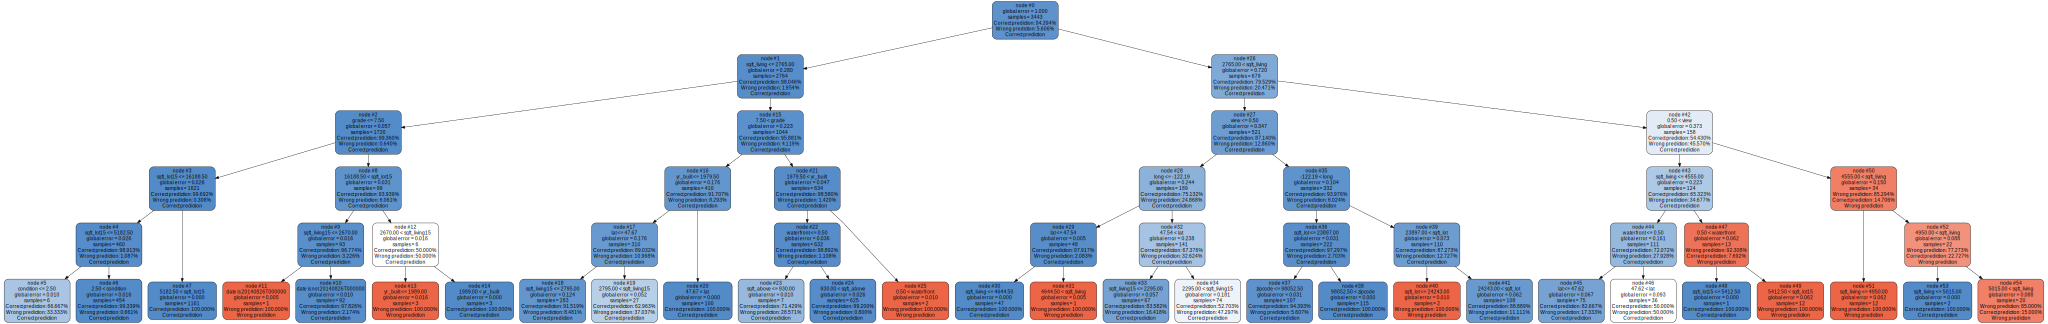

In [40]:
dku_error_visualizer.plot_error_tree(size=(25, 25))

### Explore Failure nodes

Use the `error_node_summary` function of the `DkuErrorAnalyzer` to explore the leaf nodes and have information about the samples they contain. 

The provided information covers:
1. the number of correct predictions,
2. the number of wrong predictions,
3. the leaf node _Local error_: the ratio of the number of wrongly predicted samples over the total number of samples in the node. This is equivalent to the leaf _purity_ for the error leaves (ratio of samples of the same class as the leaf class), 
4. the leaf node _Global error_: the ratio of the number of wrongly predicted samples over the total number of mispredicted samples in the test set,
5. the path to leaf: showing roughly the features behaviour for the samples in the leaf node. 

You can input leaf nodes from the tree plot above (`leaf_selector` argument).

Replace `leaf_id` with the leaf node you would like to explore (pick a red leaf for a *Failure node*). 

In [36]:
leaf_id = 54

In [37]:
dku_error_analyzer.error_node_summary(leaf_selector=leaf_id, print_summary=True, add_path_to_leaves=True);

LEAF 54:
     Correct predictions: 3 | Wrong predictions: 17 | Local error (purity): 0.85 | Global error: 0.09
     Path to leaf:
     2765.00 < sqft_living
        0.50 < view
           4555.00 < sqft_living
              4950.00 < sqft_living
                 5015.00 < sqft_living


You can also let the analyzer show you all the _Failure nodes_ ranked by importance.

In [38]:
dku_error_analyzer.error_node_summary(print_summary=True, add_path_to_leaves=True);

LEAF 49:
     Correct predictions: 0 | Wrong predictions: 12 | Local error (purity): 1.00 | Global error: 0.06
     Path to leaf:
     2765.00 < sqft_living
        0.50 < view
           sqft_living <= 4555.00
              0.50 < waterfront
                 5412.50 < sqft_lot15
LEAF 51:
     Correct predictions: 0 | Wrong predictions: 12 | Local error (purity): 1.00 | Global error: 0.06
     Path to leaf:
     2765.00 < sqft_living
        0.50 < view
           4555.00 < sqft_living
              sqft_living <= 4950.00
LEAF 13:
     Correct predictions: 0 | Wrong predictions: 3 | Local error (purity): 1.00 | Global error: 0.02
     Path to leaf:
     sqft_living <= 2765.00
        grade <= 7.50
           16188.50 < sqft_lot15
              2670.00 < sqft_living15
                 yr_built <= 1989.00
LEAF 25:
     Correct predictions: 0 | Wrong predictions: 2 | Local error (purity): 1.00 | Global error: 0.01
     Path to leaf:
     sqft_living <= 2765.00
        7.50 < grade
       

### Display the Feature Distributions of samples in the Failure nodes

You can use the `DkuErrorVisualizer` to plot the histograms of the features in the _Failure nodes_, comparing to the global population as it is a mainly successful baseline.

Again, you can either input leaf nodes by the `leaf_selector` argument.

Leaf 54 (Wrong prediction: 0.850, Correct prediction: 0.150)


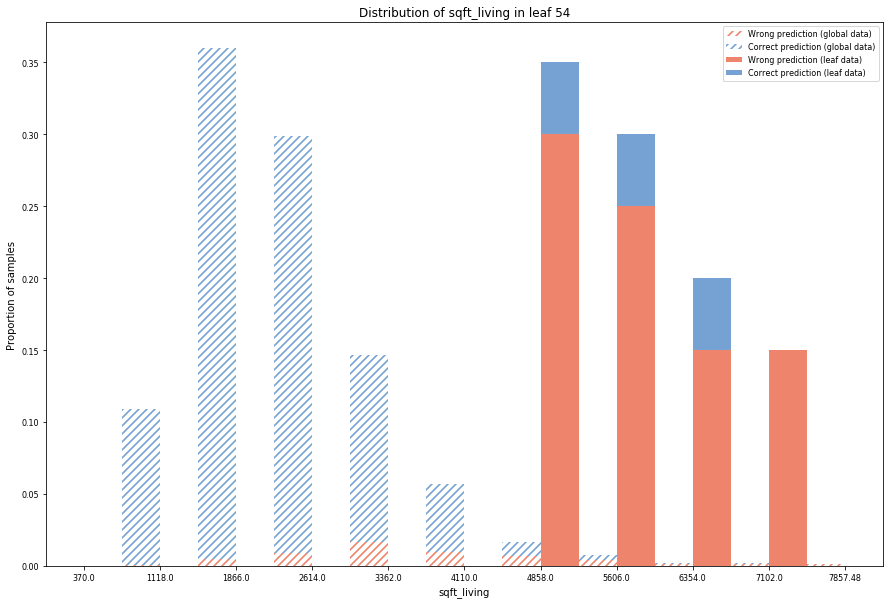

Leaf 54 (Wrong prediction: 0.850, Correct prediction: 0.150)


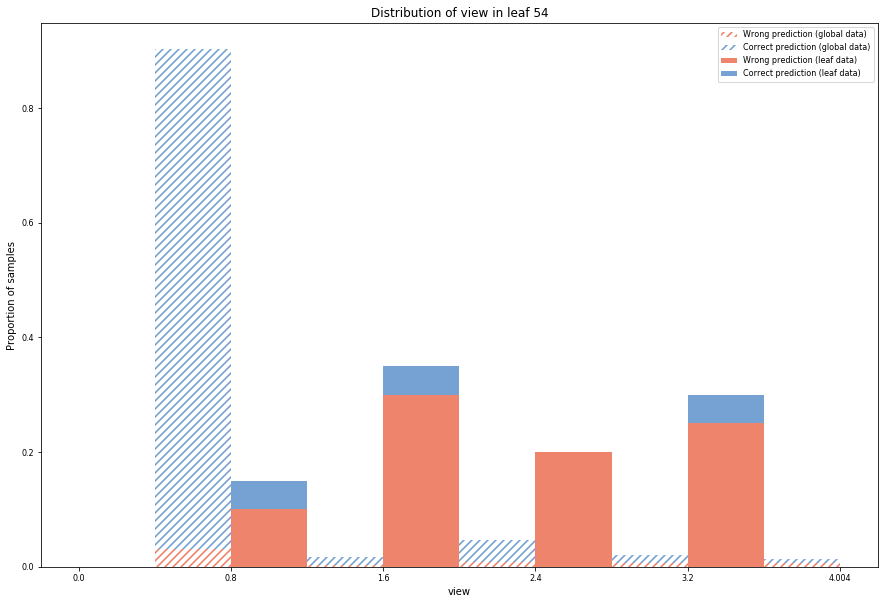

In [39]:
dku_error_visualizer.plot_feature_distributions_on_leaves(leaf_selector=leaf_id, top_k_features=3, show_class=True)

You can also let the visualizer show you the feature distributions in all the _Failure nodes_ ranked by importance.

Leaf 49 (Wrong prediction: 1.000)


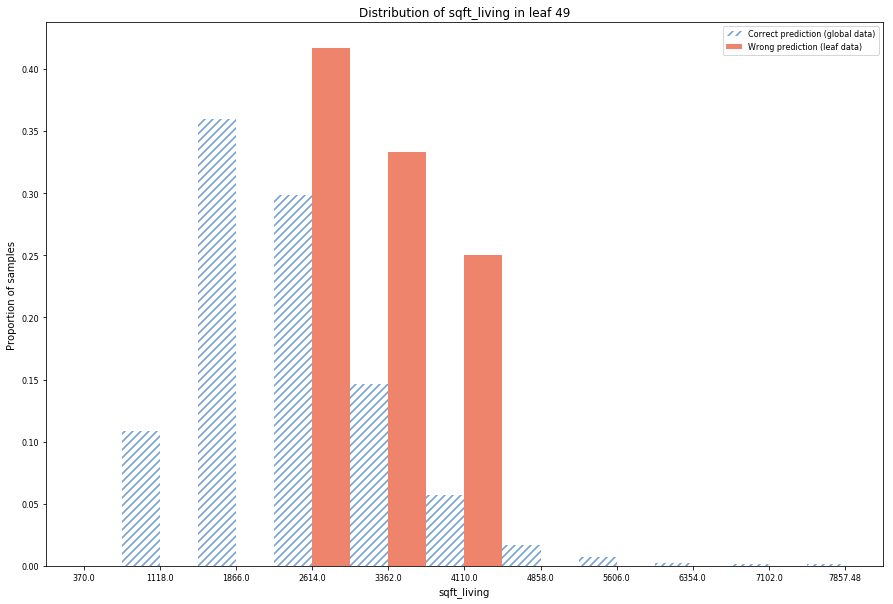

Leaf 51 (Wrong prediction: 1.000)


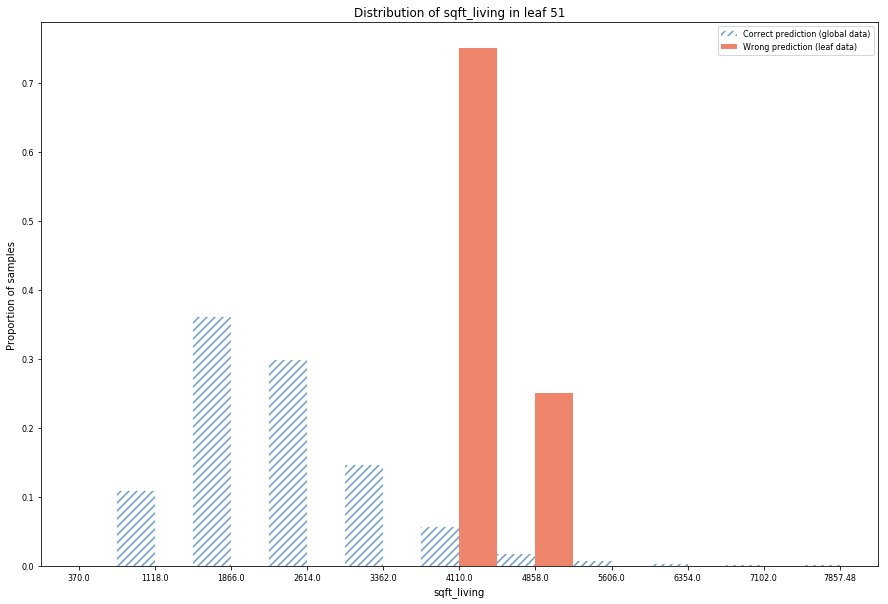

Leaf 13 (Wrong prediction: 1.000)


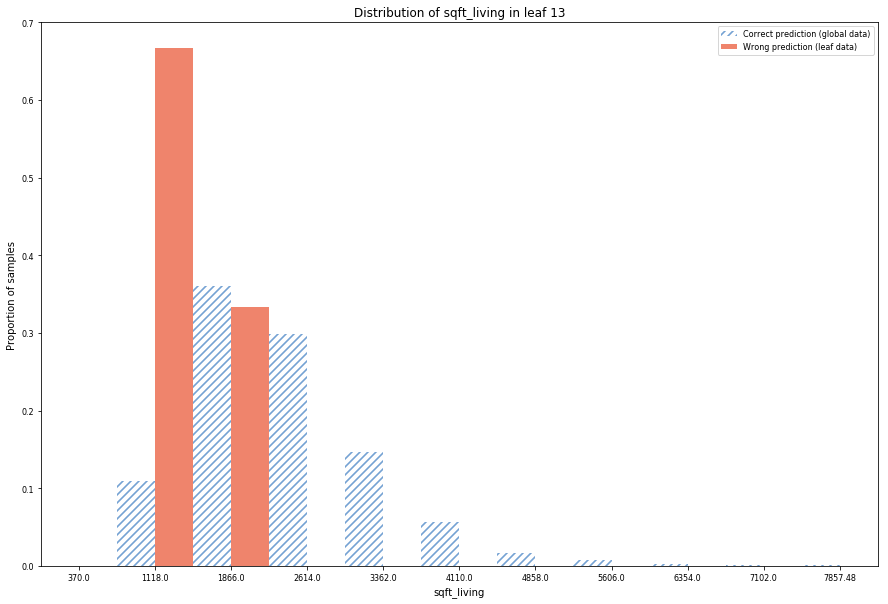

Leaf 25 (Wrong prediction: 1.000)


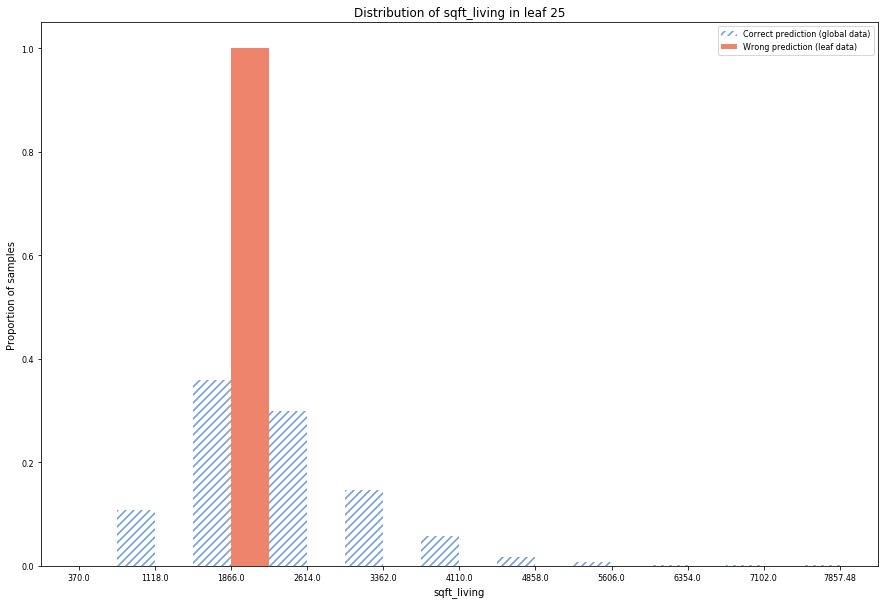

Leaf 40 (Wrong prediction: 1.000)


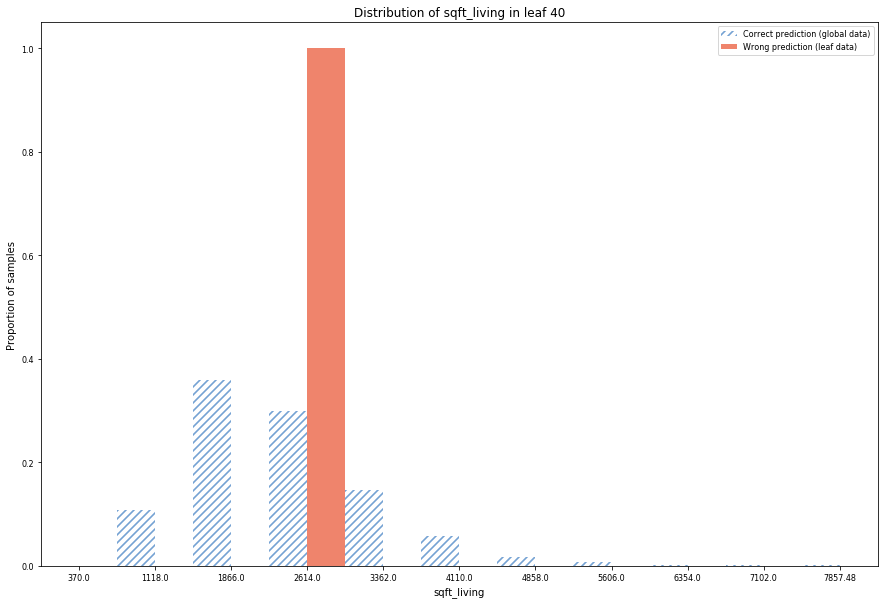

Leaf 11 (Wrong prediction: 1.000)


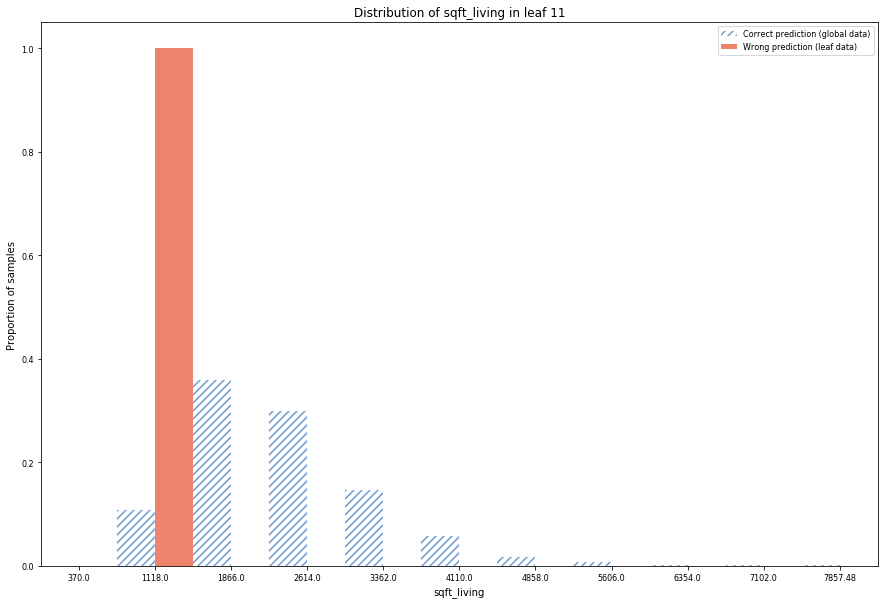

Leaf 31 (Wrong prediction: 1.000)


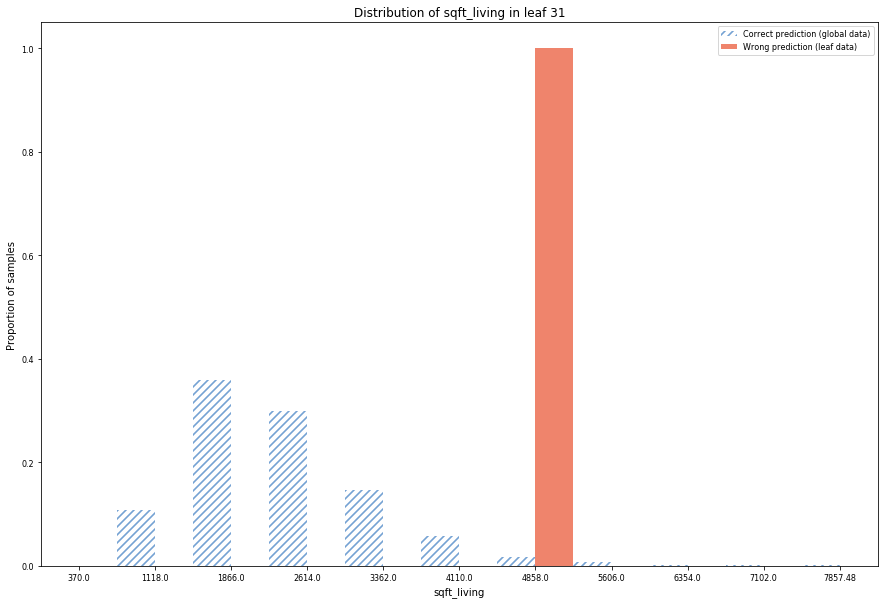

Leaf 54 (Wrong prediction: 0.850, Correct prediction: 0.150)


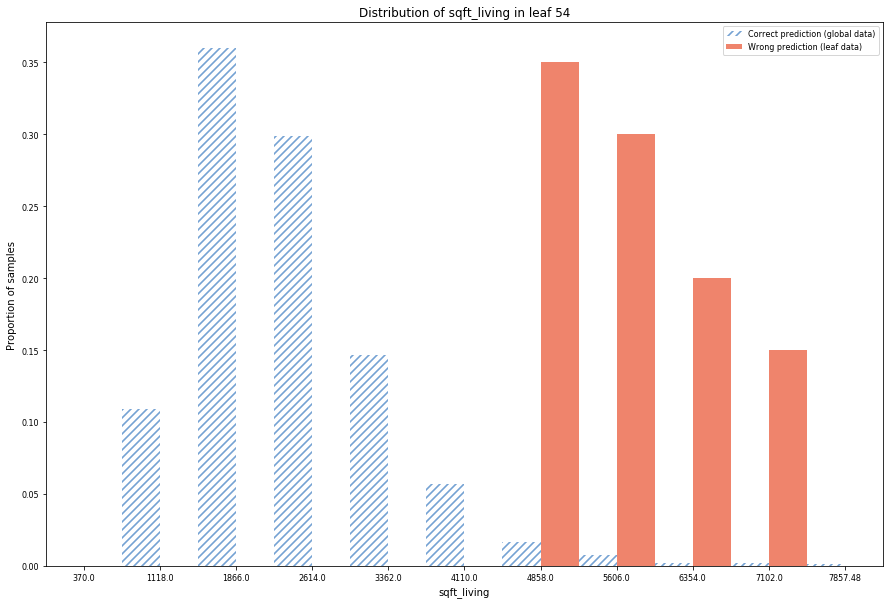

In [41]:
dku_error_visualizer.plot_feature_distributions_on_leaves(leaf_selector='all_errors', top_k_features=1)